决策树预测汽车安全性，其中包含两个模型，一是基尼系数，一是熵。

Classification and Regression Trees or CART  分类回归树：为随机森林，boosted decision trees

决策树分类：两大标准，信息增益Information gain，基尼系数Gini index
* 信息增益-熵 Entropy
 ![信息熵](http://www.learnbymarketing.com/wp-content/uploads/2016/02/entropy-formula.png)
* 基尼系数
 ![基尼系数](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRzYHkcmZKKp2sJN1HpHvw-NgqbD9EnapnbXozXRgajrSGvEnYy&s)
c 是 类的个数，pi是相关类的概率

过拟合：训练样本上的误差减少，测试样本上的误差增加，预测准确度降低
决策树的过拟合办法：
* Pre-Pruning
 - 提前停止，难度较大
* Post-Pruning：
 - 决策树建立之后修正，采用交叉验证的方式

# Start

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [9]:
# import data
df = pd.read_csv('car_evaluation.csv', header=None)  # 原数据没有列名称
df.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [11]:
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = col_names
df[:8]

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
5,vhigh,vhigh,2,2,med,high,unacc
6,vhigh,vhigh,2,2,big,low,unacc
7,vhigh,vhigh,2,2,big,med,unacc


In [26]:
df['buying'].unique(), type(df),df['doors'].unique(),df['class'].unique()

(array(['vhigh', 'high', 'med', 'low'], dtype=object),
 pandas.core.frame.DataFrame,
 array(['2', '3', '4', '5more'], dtype=object),
 array(['unacc', 'acc', 'vgood', 'good'], dtype=object))

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [19]:
# 频率分布
for col in col_names:
    print(df[col].value_counts())

vhigh    432
low      432
med      432
high     432
Name: buying, dtype: int64
vhigh    432
low      432
med      432
high     432
Name: maint, dtype: int64
2        432
3        432
5more    432
4        432
Name: doors, dtype: int64
2       576
4       576
more    576
Name: persons, dtype: int64
big      576
small    576
med      576
Name: lug_boot, dtype: int64
low     576
med     576
high    576
Name: safety, dtype: int64
unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64


In [23]:
# 选择class 深入分析
df['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

In [25]:
# missing value
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

## 声明变量和目标

In [32]:
X = df.drop('class', axis=1)  # 0 行，1 列
y = df['class']

In [35]:
# 切分数据
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((1157, 6), (571, 6))

## 特征工程

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1157 entries, 48 to 1126
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1157 non-null   object
 1   maint     1157 non-null   object
 2   doors     1157 non-null   object
 3   persons   1157 non-null   object
 4   lug_boot  1157 non-null   object
 5   safety    1157 non-null   object
dtypes: object(6)
memory usage: 63.3+ KB


In [38]:
# X_train.head()
X_test.head()

,buying,maint,doors,persons,lug_boot,safety
599,high,high,4,2,med,high
1201,med,low,2,4,med,med
628,high,high,5more,2,big,med
1498,low,high,5more,4,med,med
1263,med,low,4,more,med,low


所有数据都是类别数据，O-Object

In [42]:
# Encode categorical features as an integer array.
import category_encoders  as ce
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

X_train = encoder.fit_transform(X_train)  # Fit to data, then transform it, build a eoncoder
X_test = encoder.transform(X_test)   # Transform X to ordinal codes.

In [44]:
# X_train.head()
X_test.head()

,buying,maint,doors,persons,lug_boot,safety
599,2,2,4,3,1,2
1201,4,3,3,2,1,3
628,2,2,2,3,3,3
1498,3,2,2,2,1,3
1263,4,3,4,1,1,1


# 模型一 基尼系数决策树

In [45]:
# import DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [46]:
y_pred_gini = clf_gini.predict(X_test)   # 预测数据

In [47]:
# check accuracy
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.8021


In [48]:
# 比较训练数据
y_pred_train_gini = clf_gini.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))
y_pred_train_gini

Training-set accuracy score: 0.7865


array(['unacc', 'unacc', 'unacc', ..., 'unacc', 'unacc', 'acc'],
      dtype=object)

In [49]:
# 检查过拟合和欠拟合情况
print('Training set score: {:.4f}'.format(clf_gini.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 0.7865
Test set score: 0.8021


[Text(267.84000000000003, 380.52, 'X[5] <= 1.5\ngini = 0.455\nsamples = 1157\nvalue = [255, 49, 813, 40]'),
 Text(133.92000000000002, 271.8, 'gini = 0.0\nsamples = 386\nvalue = [0, 0, 386, 0]'),
 Text(401.76000000000005, 271.8, 'X[3] <= 2.5\ngini = 0.577\nsamples = 771\nvalue = [255, 49, 427, 40]'),
 Text(267.84000000000003, 163.07999999999998, 'X[0] <= 2.5\ngini = 0.631\nsamples = 525\nvalue = [255, 49, 181, 40]'),
 Text(133.92000000000002, 54.360000000000014, 'gini = 0.496\nsamples = 271\nvalue = [124, 0, 147, 0]'),
 Text(401.76000000000005, 54.360000000000014, 'gini = 0.654\nsamples = 254\nvalue = [131, 49, 34, 40]'),
 Text(535.6800000000001, 163.07999999999998, 'gini = 0.0\nsamples = 246\nvalue = [0, 0, 246, 0]')]

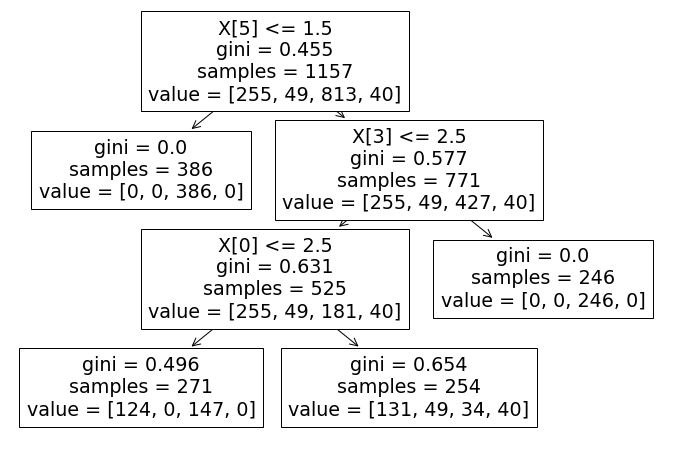

In [53]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_gini.fit(X_train, y_train)) 

Visualize decision-trees with graphviz

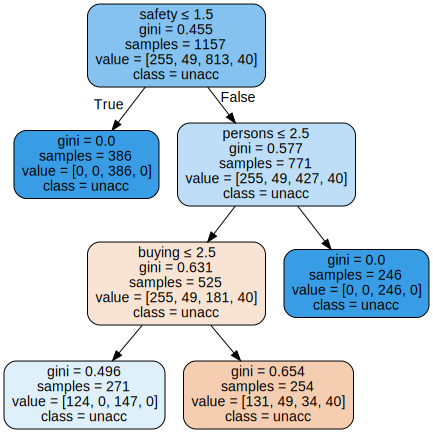

In [56]:
import graphviz 
dot_data = tree.export_graphviz(clf_gini, out_file=None, 
                              feature_names=X_train.columns,  
                              class_names=y_train,  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 

graph 

# 模型二 熵 决策树

In [57]:
clf_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


# fit the model
clf_en.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [58]:
y_pred_en = clf_en.predict(X_test)
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.8021


In [59]:
y_pred_train_en = clf_en.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))
y_pred_train_en

Training-set accuracy score: 0.7865


array(['unacc', 'unacc', 'unacc', ..., 'unacc', 'unacc', 'acc'],
      dtype=object)

In [60]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf_en.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf_en.score(X_test, y_test)))

Training set score: 0.7865
Test set score: 0.8021


[Text(401.76000000000005, 380.52, 'X[3] <= 2.5\nentropy = 1.216\nsamples = 571\nvalue = [129, 20, 397, 25]'),
 Text(267.84000000000003, 271.8, 'X[5] <= 1.5\nentropy = 1.506\nsamples = 370\nvalue = [129, 20, 196, 25]'),
 Text(133.92000000000002, 163.07999999999998, 'entropy = 0.0\nsamples = 127\nvalue = [0, 0, 127, 0]'),
 Text(401.76000000000005, 163.07999999999998, 'X[0] <= 2.5\nentropy = 1.635\nsamples = 243\nvalue = [129, 20, 69, 25]'),
 Text(267.84000000000003, 54.360000000000014, 'entropy = 1.0\nsamples = 113\nvalue = [56, 0, 57, 0]'),
 Text(535.6800000000001, 54.360000000000014, 'entropy = 1.658\nsamples = 130\nvalue = [73, 20, 12, 25]'),
 Text(535.6800000000001, 271.8, 'entropy = 0.0\nsamples = 201\nvalue = [0, 0, 201, 0]')]

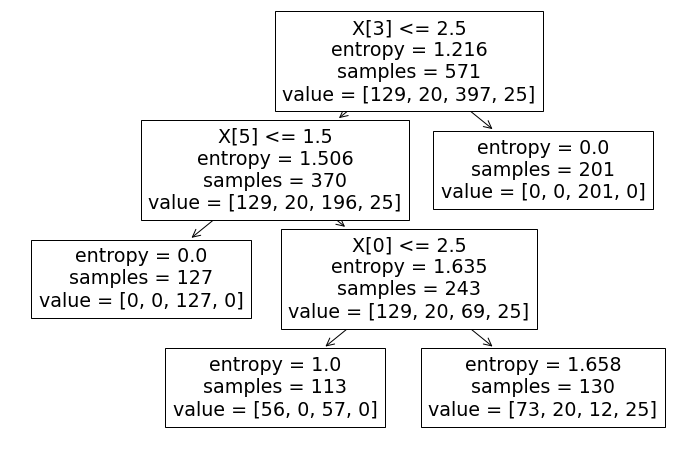

In [63]:
plt.figure(figsize=(12,8))

from sklearn import tree

tree.plot_tree(clf_en.fit(X_train, y_train))  # 换成测试数据

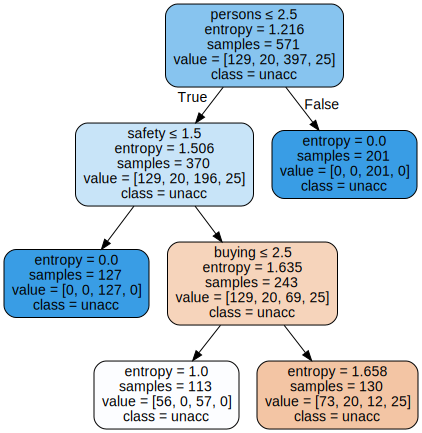

In [64]:
import graphviz 
dot_data = tree.export_graphviz(clf_en, out_file=None, 
                              feature_names=X_train.columns,  
                              class_names=y_train,  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 

graph 

## 混淆矩阵 Confusion matrix

In [66]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_en)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 73   0  56   0]
 [ 20   0   0   0]
 [ 12   0 385   0]
 [ 25   0   0   0]]


## Classification Report

In [68]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_en))

              precision    recall  f1-score   support

         acc       0.56      0.57      0.56       129
        good       0.00      0.00      0.00        20
       unacc       0.87      0.97      0.92       397
       vgood       0.00      0.00      0.00        25

    accuracy                           0.80       571
   macro avg       0.36      0.38      0.37       571
weighted avg       0.73      0.80      0.77       571



这个项目建立了两棵决策树：
- 基尼系数 决策树确度0.8021， 训练样本准确度0.7865
- 熵标准 决策树准确度 0.8021， 训练样本准确度0.7865
 - 结果一致的原因可能是样本数据比较小


最后生成的混淆矩阵和分类报告显较好的决策树性能